# Introduction

In this notebook, we will explore a customer segmentation and their result. As there is plenty of Kernel with a clear explaination of the cleanup, I'll just do it quickly without a lot of information. More explanation will be given on the preparation of the dataset and the result parts. 

# Summary

The Notebook is divided in 5 parts as follow:

<ul>
<li>Pre-Processing</li>
<ul>
<li>Classic Cleanup</li>
<li>Customer Country</li>
</ul>
<li>Data Preparation on Articles</li>
<ul>
<li>Preparation of Matrices</li>
<li>Clustering</li>
<li>Analysis</li>
</ul>
<li>New Datasets per Invoice</li>
<li>New Dataset per Customer</li>
<ul>
<li>Preparation for Clustering</li>
<li>Clustering</li>
<li>Analysis</li>
</ul>
<li>Building Model</li>
</ul>

Now we can start !


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import scipy.sparse
import matplotlib.pyplot as plt
import nltk
import random
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline

# Pre-Processing 

### Classic Cleanup

In this part, I'll handle Cancelled Orders, remove all descriptions which means that the object is lost and so on. All invoces from the customer will be removed as well as Shipping costs (StockCode = POST or DOT). A new feature for the Price of each line will be created and some outliers (in term of Unit Price or Qty) will be remove if and only if there is a cancellation existing. There is for example 40k article bought and cancelled just after with the same article/customer. Without cancellation, I'll consider that it's not a mistake.

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Customer-Segmentation/data.csv", encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Handle cancellation as new feature
df["Cancelled"] = df["InvoiceNo"].str.startswith("C")
df["Cancelled"] = df["Cancelled"].fillna(False)

# Hnadle incorrect Description
df = df[df["Description"].str.startswith("?") == False]
df = df[df["Description"].str.isupper() == True]
df = df[df["Description"].str.contains("LOST") == False]
df = df[df["CustomerID"].notnull()]
df["CustomerID"] = df["CustomerID"].astype(int)

# Convert Invoice Number to integer as we already consider Cancellation as new feature
df['InvoiceNo'].replace(to_replace="\D+", value=r"", regex=True, inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('int')

# remove shiping invoices
df = df[(df["StockCode"] != "DOT") & (df["StockCode"] != "POST")]
df.drop("StockCode", inplace=True, axis=1)

# remove outliers by qty
qte_false = [74215, 3114, 80995]  # fond during exploration but not done here (found with a boxplot on qty or price)
for qte in qte_false:
    df = df[(df["Cancelled"] == False) & (df["Quantity"] !=qte)]

# Now we can only keep the order without cancellation
df = df[df["Cancelled"] == False]
df.drop("Cancelled", axis=1, inplace=True)

# We can create the feature Price
df["Price"] = df["UnitPrice"] * df["Quantity"]

# convert date to proper datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395143 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    395143 non-null  int64         
 1   Description  395143 non-null  object        
 2   Quantity     395143 non-null  int64         
 3   InvoiceDate  395143 non-null  datetime64[ns]
 4   UnitPrice    395143 non-null  float64       
 5   CustomerID   395143 non-null  int64         
 6   Country      395143 non-null  object        
 7   Price        395143 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 27.1+ MB


Now the dataset starts to be clean, we can now convert our Countries to a value. To do so, we will rank them based on their impact of the revenue.

### Handling Customer Country

As mentionned above, here we can think about encoding Country to their rank based on their impact on the Revenue. Let's look at values for number of invoices per country and the revenue per country.

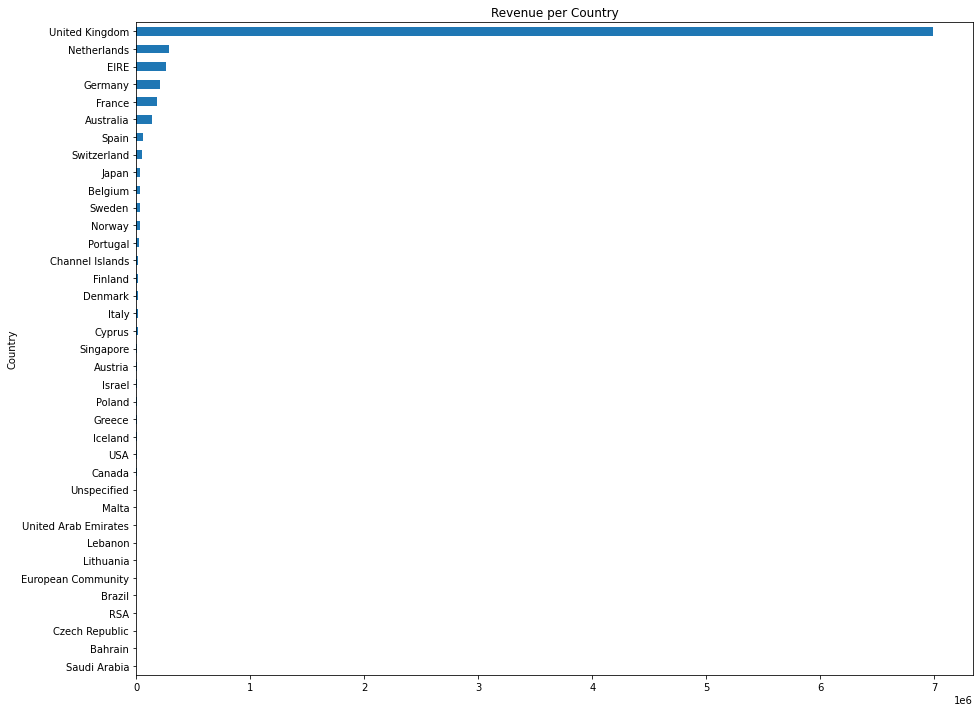

In [6]:
revenue_per_countries = df.groupby(["Country"])["Price"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")
plt.show()

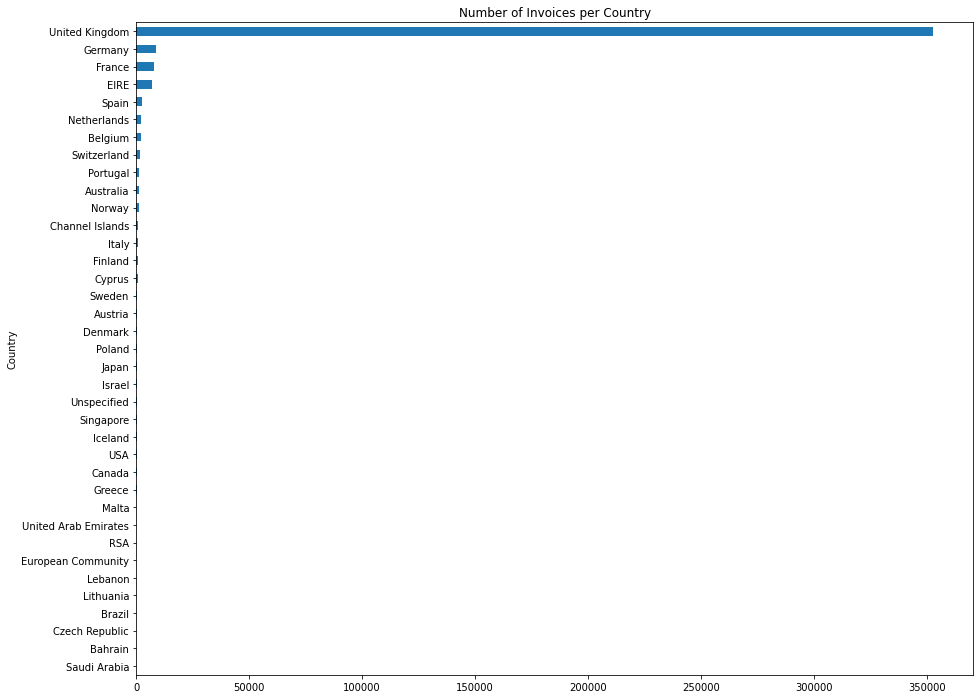

In [7]:
No_invoice_per_country = df.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Invoices per Country")
plt.show()

We can see that for example Netherland bring more money with less Invoices. That means we may order country by their average purchase price instead of only the price or the quantity. Now the strategy changed.

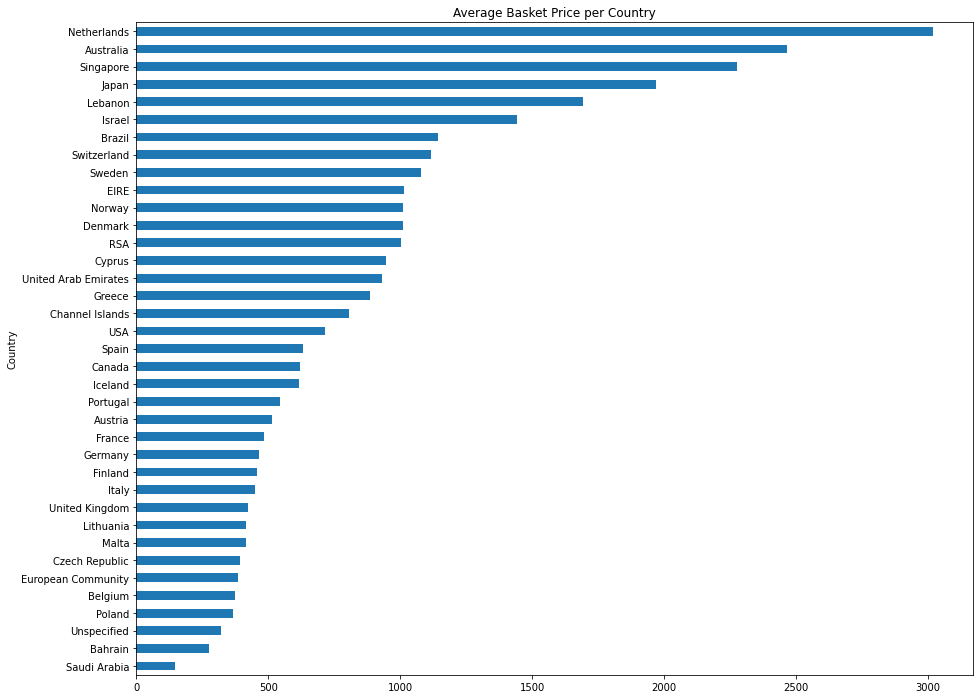

In [8]:
best_buyer = df.groupby(["Country", "InvoiceNo"])["Price"].sum().reset_index().groupby(["Country"])["Price"].mean().sort_values()
best_buyer.plot(kind='barh', figsize=(15,12))
plt.title("Average Basket Price per Country")
plt.show()

That's it, we now have a cleaner scale as the country won't be biaised by the huge number of order comming from UK. It's also a good indicator on where the Shop should expand his market. If I were him, I'd think about Netherlands ! Now let's encode the country.

In [9]:
encoder_countries = best_buyer.rank().to_dict()
decoder_countries = {i: j for i, j in encoder_countries.items()}

df["Country"]  = df["Country"].apply(lambda x:encoder_countries[x])

# Preparation of articles

Now we have only 1 feature remaining to pre-process before to go on, it's the articles descriptions. To do so, we will first generate a Term-Frequency Matrix and a Term-Frequency Invert Document-Frequency Matrix with all uniques articles. Then we will prepare this matrix to be able to run a clustering on it. The clustering will be tried with multiple size of clusters. The best parameter will be used an analysis of the content will be done in order to check that it's relevant.

In [10]:
X = df["Description"].unique()

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
X = df["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = CountVectorizer().build_analyzer()
CV = CountVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter)
TF_matrix = CV.fit_transform(X)
print("TF_matrix :", TF_matrix.shape, "of", TF_matrix.dtype)

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_matrix : (3853, 1686) of int64
TF_IDF_matrix : (3853, 1686) of float64


So there is no word which appears in more than a third of our dataset. We can now think about which matrix should we use ? Both matrices are very sparse so before to do the clustering, we should ensure that we will be able to compute proper distances. The thing to do in such case, it's to go throught the TruncatedSVD. I used 100 output features but we may increase it. 100 is the default value to perform what is called Latent Semantic Analysis. Both matrices will be full of float64 numbers. After Normalization to have a norm of 1 for each row, we can do a clustering.

In [14]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_embedded = svd.fit_transform(TF_matrix)
TF_embedded = normalizer.fit_transform(TF_embedded)
print("TF_embedded :", TF_embedded.shape, "of", TF_embedded.dtype)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_embedded : (3853, 100) of float64
TF_IDF_embedded : (3853, 100) of float64


For the clustering, we can check the Silhouette Score. If we do that with multiple number of cluster we will see that there is a flat after 60 clusters. To dertermine the best choice after that, we can also take a look at the number of articles in both clusters. If all articles are in 1 cluters, that lean the clustering is very poor. We can also take a look at the distribution of article per clusters. 

In [15]:
score_tf = []
score_tfidf = []
mean_tf = []
std_tf = []
mean_tfidf = []
std_tfidf = []

x = list(range(5, 105, 5))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_embedded)
    clusters = kmeans.predict(TF_embedded)
    silhouette_avg = silhouette_score(TF_embedded, clusters)
#     print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tf.append(silhouette_avg)
    mean_tf.append(rep.mean())
    std_tf.append(rep.std())

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)
#     print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)
    mean_tfidf.append(rep.mean())
    std_tfidf.append(rep.std())

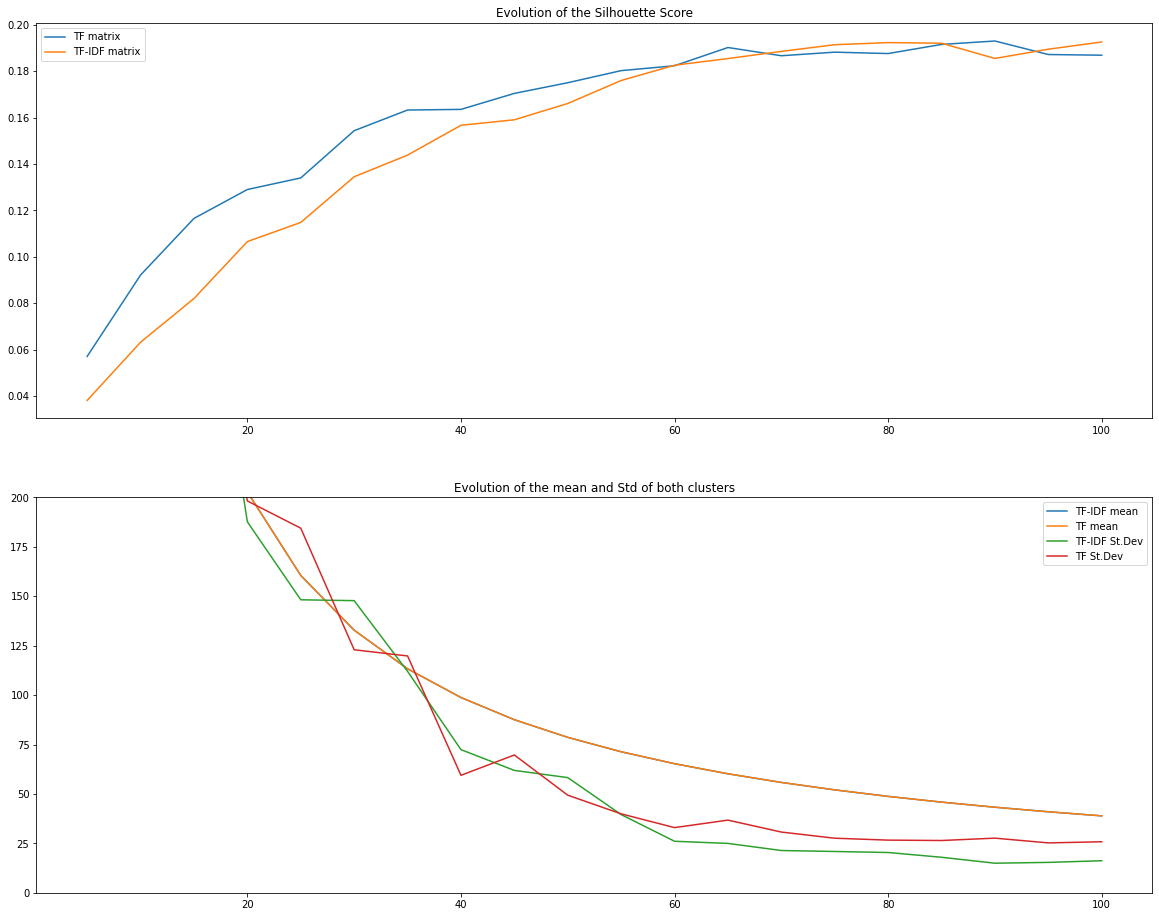

In [16]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tf, label="TF matrix")
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, mean_tfidf, label="TF-IDF mean")
plt.plot(x, mean_tf, label="TF mean")
plt.plot(x, std_tfidf, label="TF-IDF St.Dev")
plt.plot(x, std_tf, label="TF St.Dev")
plt.ylim(0, 200)
plt.title("Evolution of the mean and Std of both clusters")
plt.legend()

plt.show()

We can see that 100 cluster is the value where the silhouette score is the highest and and Std Dev minimum. In term of choice, we should select the matrix TF-IDF instead of TF as the score is highest after 60 clusters. Let's do a final clustering with 100 cluster. and we can explore the content of some clusters by using cloudword.

In [17]:
n_clusters = 100

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=42)
kmeans.fit(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)

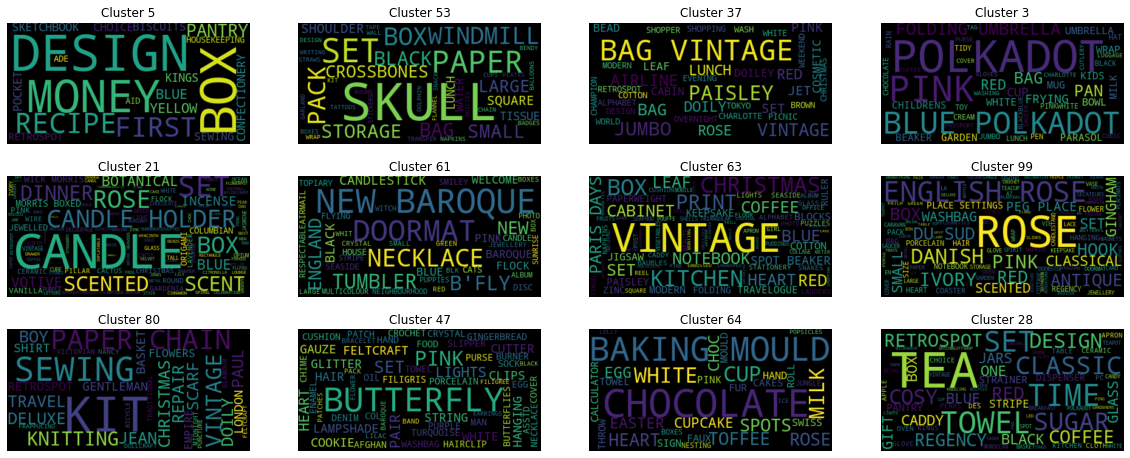

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()
plt.show()

We can see that the content is different for both clusters and the balance is quite good from the calculation. We can consider it as a good clustering. We can now map the article to the cluster.

In [19]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

We can also take a look at the position of clusters in space with TSNE. A good alternative and faster is UMAP (https://github.com/lmcinnes/umap)

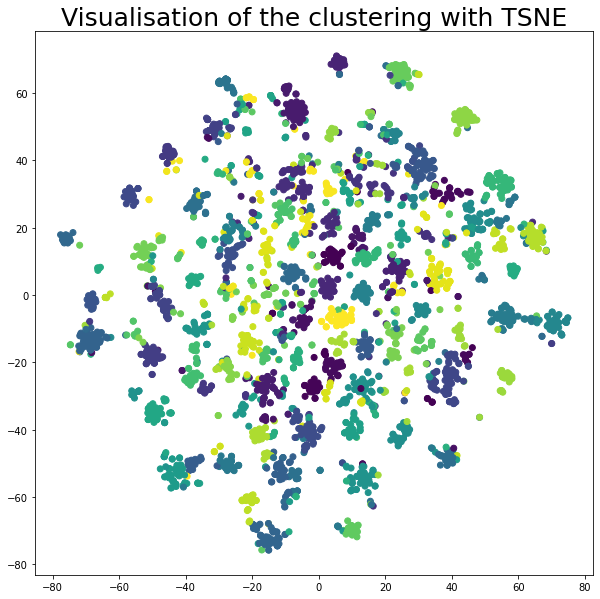

In [20]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualisation of the clustering with TSNE", fontsize="25")
plt.show()

# Modelization

### Intermediate dataset grouped by invoices

Now we have everything to start the preparation of the final dataset. First we will One-Hot-Encode the price spent on every cluster par invoices. In parralleel, we will also perform a groupby on the dataset initial before to merge them.

In [24]:
cluster = df['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Article_cluster").mul(df["Price"], 0)
df2 = pd.concat([df['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [25]:
custom_aggregation = {}
custom_aggregation["Price"] = "sum"
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"

df_grouped = df.groupby("InvoiceNo").agg(custom_aggregation)

In [26]:
# let create recency for every Invoice
now = df_grouped["InvoiceDate"].max()  # as the dataset is not done in the present
df_grouped["Recency"] = now - df_grouped["InvoiceDate"]
df_grouped["Recency"] = pd.to_timedelta(df_grouped["Recency"]).astype("timedelta64[D]") # conversion to day from now

# add features required for the next groupby
df_grouped["nb_visit"] = 1
df_grouped["total_spent"] = 1

### Final Dataset per customer

In [27]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [28]:
custom_aggregation = {}
custom_aggregation["Price"] = ["mean", "sum"]
custom_aggregation["nb_visit"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Recency"] = ["min", "max"]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [29]:
df_grouped_final["Freq"] = (df_grouped_final["Recency"]["max"]  - df_grouped_final["Recency"]["min"] ) / df_grouped_final["nb_visit"]["sum"]
df_grouped_final.columns = ["avg_price", "sum_price", "nb_visit", "country", "quantity", "min_recency", "max_recency", "freq"]

In [34]:
df_grouped_final.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq
CustomerID,,,,,,,,
12347,615.714286,4310.00,7,17.0,2458,1.0,366.0,52.142857
12348,359.310000,1437.24,4,12.0,2332,74.0,357.0,70.750000
12349,1457.550000,1457.55,1,11.0,630,18.0,18.0,0.000000
12350,294.400000,294.40,1,27.0,196,309.0,309.0,0.000000
12352,197.962857,1385.74,7,27.0,526,35.0,296.0,37.285714


### Clustering

Now we have our 2 datasets. we won't merge them as there is not the same scaling. The scaling has to be done upfront. One dataset has raw values and the other one is scaled by row to have the percentage on every cluster. Now we will do a clustering and check the number of clusters required to explain all kind of customer (nevertheless, in order to be able to explain every group, the number of cluster will be limited to 10).

In [36]:
X1 = df_grouped_final.values 
X2 = df2_grouped_final.values

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

scaler = MinMaxScaler()
X1 = scaler.fit_transform(X1)
X_final_minmax_scale = np.concatenate((X1, X2), axis=1)

In [37]:
x = list(range(2, 10))
y_std = []
y_minmax = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")
    
    kmeans.fit(X_final_minmax_scale)
    clusters = kmeans.predict(X_final_minmax_scale)
    silhouette_avg = silhouette_score(X_final_minmax_scale, clusters)
    y_minmax.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with MinMax Scaling")

n_clusters = 2
The average silhouette_score is : 0.8569686009106471 with Std Scaling
The average silhouette_score is : 0.24668516568394228 with MinMax Scaling
n_clusters = 3
The average silhouette_score is : 0.2888826383972608 with Std Scaling
The average silhouette_score is : 0.29290579099396896 with MinMax Scaling
n_clusters = 4
The average silhouette_score is : 0.3539063531668293 with Std Scaling
The average silhouette_score is : 0.20438112547311815 with MinMax Scaling
n_clusters = 5
The average silhouette_score is : 0.37432619806854667 with Std Scaling
The average silhouette_score is : 0.18699244377252694 with MinMax Scaling
n_clusters = 6
The average silhouette_score is : 0.3831023044417514 with Std Scaling
The average silhouette_score is : 0.14938311826803674 with MinMax Scaling
n_clusters = 7
The average silhouette_score is : 0.3616816761922991 with Std Scaling
The average silhouette_score is : 0.15174719177389767 with MinMax Scaling
n_clusters = 8
The average silhouette_score i

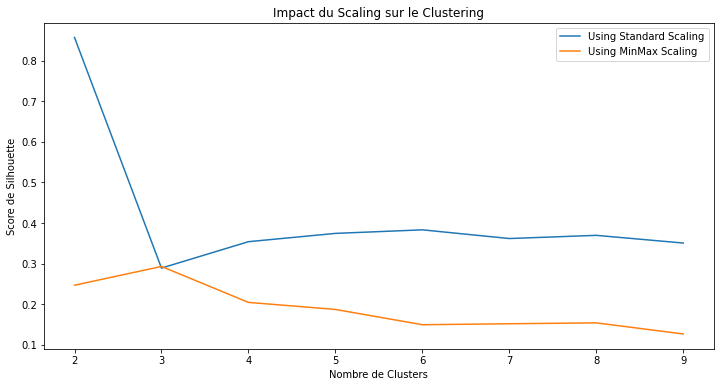

In [38]:
plt.figure(figsize=(12,6))

plt.plot(x, y_std, label="Using Standard Scaling")
plt.plot(x, y_minmax, label="Using MinMax Scaling")

plt.legend()
plt.xlabel("Nombre de Clusters")
plt.ylabel("Score de Silhouette")
plt.title("Impact du Scaling sur le Clustering")
plt.xticks(x)

plt.show()

At cluster = 2, the score is clearly high beacuse the cluster group nearly all customers, we should focus only on higher sizes. On it we can see that the Standard Scaling is clearly better. Regarding the score, the best number of cluster seems to be 6. We can take a look at the histogram just to ensure that there is a balance even if we may have few customer really differents.

In [39]:
kmeans = KMeans(init='k-means++', n_clusters = 6, n_init=30, random_state=42)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

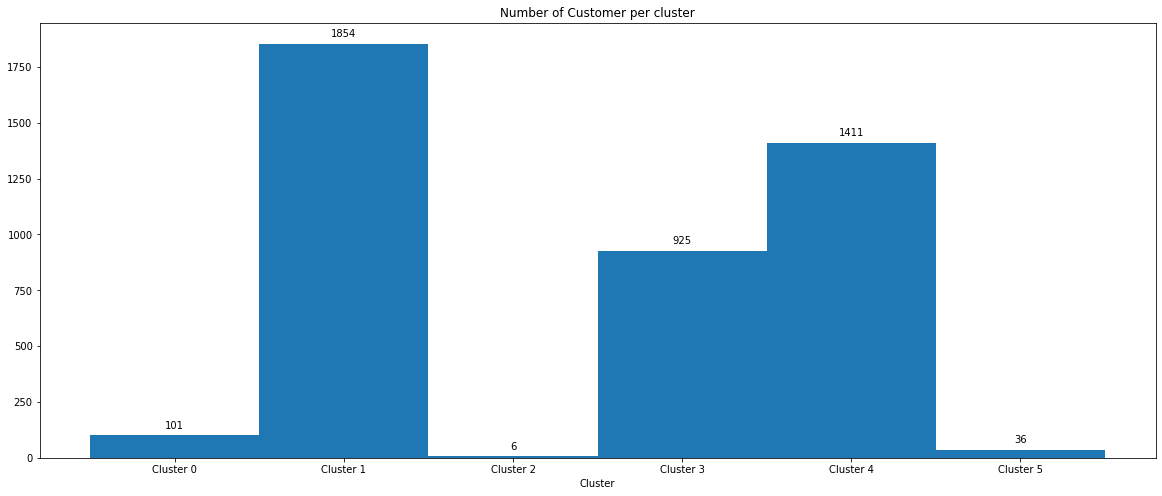

In [40]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=6) # arguments are passed to np.histogram
plt.xlabel("Cluster")
plt.title("Number of Customer per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(6)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.

plt.show()

We have 1 cluster really empty (#4) with 6 customers, 2 very low (#2 and #3) and 3 quite balance (#0, #1 and #5). Let's now explore them. The small cluster may be very good or bad customers...

### Analysis

We will now used raw datas or the dataset of percentage per cluster to explore all types of customers. Let's start with a visualisation with TSNE as we did previously.

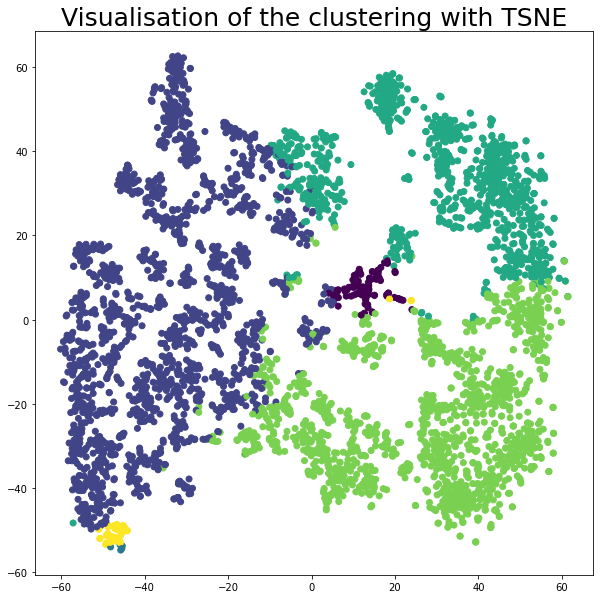

In [41]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualisation of the clustering with TSNE", fontsize="25")
plt.show()

We can also compare both cluster based on the frequency of purchase and the average price.

In [42]:
df_grouped_final["cluster"] = clusters
df_grouped_final.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq,cluster
CustomerID,,,,,,,,,
12347,615.714286,4310.00,7,17.0,2458,1.0,366.0,52.142857,1
12348,359.310000,1437.24,4,12.0,2332,74.0,357.0,70.750000,1
12349,1457.550000,1457.55,1,11.0,630,18.0,18.0,0.000000,4
12350,294.400000,294.40,1,27.0,196,309.0,309.0,0.000000,0
12352,197.962857,1385.74,7,27.0,526,35.0,296.0,37.285714,0


In [43]:
# custom_aggregation = {}
# custom_aggregation["avg_price"] = "mean"
# custom_aggregation["nb_visit"] = "mean"
# custom_aggregation["Country"] = lambda x:x.iloc[0]
# custom_aggregation["min_recency"] = "mean"
# custom_aggregation["max_recency"] = ["min", "max"]

# df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

df_analysis = df_grouped_final.groupby("cluster").mean()
df_analysis.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq
cluster,,,,,,,,
0,1008.753734,2436.389505,2.663366,28.841584,1332.980198,107.267327,216.900990,29.822230
1,358.896079,2347.480016,6.403452,10.211974,1382.869471,41.596009,302.895361,59.309733
2,3574.186403,185895.701667,75.500000,24.833333,91219.666667,6.666667,361.166667,7.152145
3,295.087323,447.227612,1.556757,10.190270,246.176216,257.812973,277.801081,7.300595
4,355.202113,674.212298,1.949681,10.246634,444.146704,49.488306,76.423813,8.683028


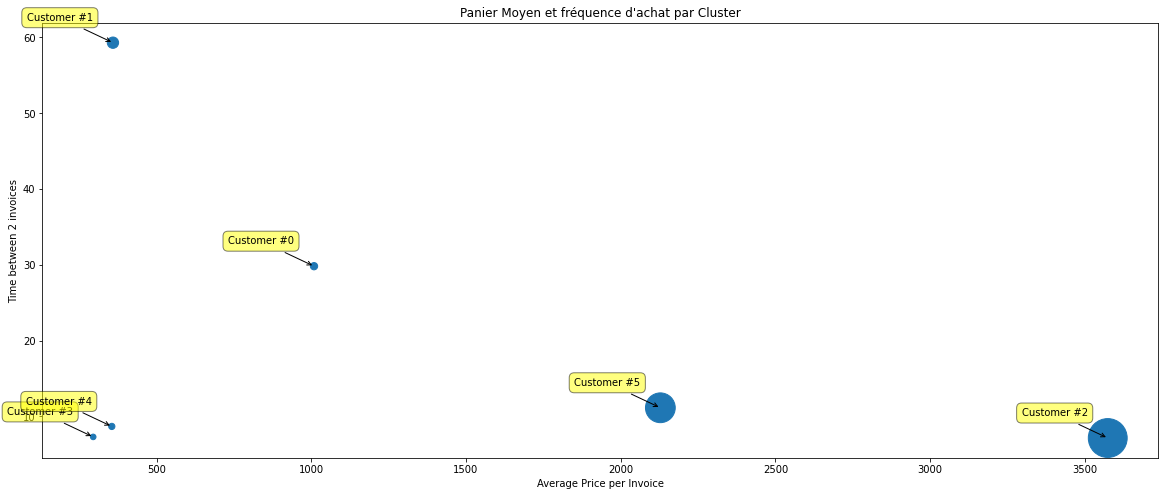

In [44]:
price = df_analysis["avg_price"].values
freq = df_analysis["freq"].values
visit = df_analysis["nb_visit"].values

plt.figure(figsize = (20,8))
plt.scatter(price, freq, s=visit*20)
    
for label, x, y in zip(["Customer #{}".format(x) for x in range(6)], price, freq):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
plt.title("Panier Moyen et fréquence d'achat par Cluster")
plt.xlabel("Average Price per Invoice")
plt.ylabel("Time between 2 invoices")

plt.show()

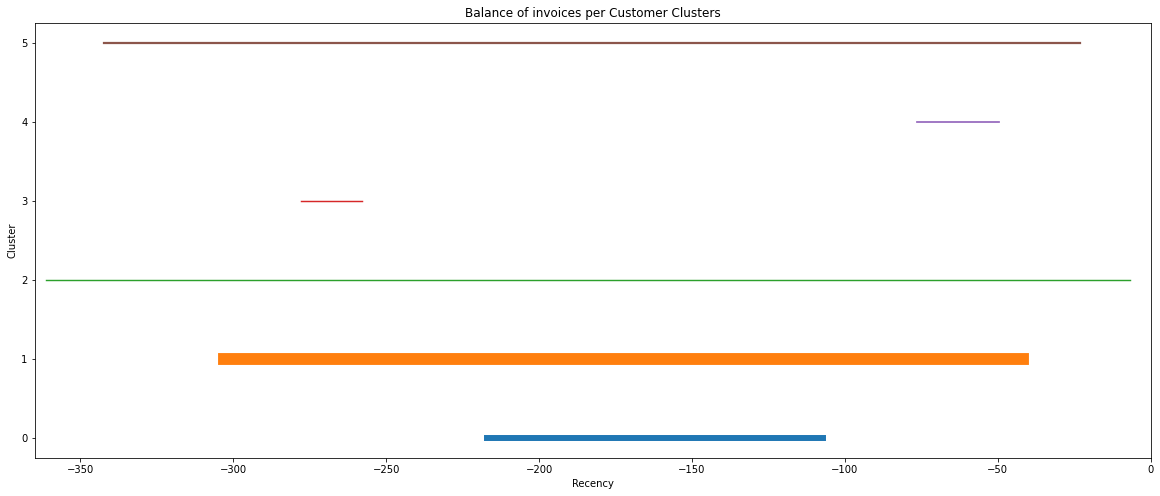

In [45]:
x_max = df_analysis["min_recency"].values
x_min = df_analysis["max_recency"].values
freq = df_analysis["freq"].values

plt.figure(figsize = (20,8))
for i in range(6):
    plt.plot([-x_min[i] , -x_max[i]], [i, i], linewidth=freq[i]/5)

plt.xlim(-365, 0)
plt.title("Balance of invoices per Customer Clusters")
plt.xlabel("Recency")
plt.ylabel("Cluster")
plt.show()

The previous plots highlight the differences between clusters. 

The cluster #4 is having a very high mean price (3600 € per basket) and very often (every 5 days). If we take a look at histogramme of number of customer, we can see that this small group of people should be considered as V.I.P. and should be handled like "outliers". In term of history, we can also see that it's old customers and still active so probably happy from our store.  

In term of frequency, we can see that there is 2 clusters with also a good frequency but a small basket (#0 and #1). If we take a look at the "history", we can see that it's customer who already purchase few time and we were not able to convert them to frequent customer. Unfortunately, the 2 cluster group more that 2350 customers. They probably join the store for a specific discount. 

To finish, if we take a look at the cluster #5 grouping 1850 customers, we can see that they order not very often but in a correct quantity (360€ every 60 days). We should maintain the fidelity of this group as it represent also an important part of the Revenue.

Now let see what every cluster is purchasing

In [46]:
purchase_mean = df2_grouped_final.set_index(clusters).groupby(clusters).mean()
purchase_mean.head()

,Article_cluster_0,Article_cluster_1,Article_cluster_2,Article_cluster_3,Article_cluster_4,Article_cluster_5,Article_cluster_6,Article_cluster_7,Article_cluster_8,Article_cluster_9,Article_cluster_10,Article_cluster_11,Article_cluster_12,Article_cluster_13,Article_cluster_14,Article_cluster_15,Article_cluster_16,Article_cluster_17,Article_cluster_18,Article_cluster_19,Article_cluster_20,Article_cluster_21,Article_cluster_22,Article_cluster_23,Article_cluster_24,Article_cluster_25,Article_cluster_26,Article_cluster_27,Article_cluster_28,Article_cluster_29,Article_cluster_30,Article_cluster_31,Article_cluster_32,Article_cluster_33,Article_cluster_34,Article_cluster_35,Article_cluster_36,Article_cluster_37,Article_cluster_38,Article_cluster_39,...,Article_cluster_60,Article_cluster_61,Article_cluster_62,Article_cluster_63,Article_cluster_64,Article_cluster_65,Article_cluster_66,Article_cluster_67,Article_cluster_68,Article_cluster_69,Article_cluster_70,Article_cluster_71,Article_cluster_72,Article_cluster_73,Article_cluster_74,Article_cluster_75,Article_cluster_76,Article_cluster_77,Article_cluster_78,Article_cluster_79,Article_cluster_80,Article_cluster_81,Article_cluster_82,Article_cluster_83,Article_cluster_84,Article_cluster_85,Article_cluster_86,Article_cluster_87,Article_cluster_88,Article_cluster_89,Article_cluster_90,Article_cluster_91,Article_cluster_92,Article_cluster_93,Article_cluster_94,Article_cluster_95,Article_cluster_96,Article_cluster_97,Article_cluster_98,Article_cluster_99
0,0.005131,0.009714,0.002438,0.025446,0.008121,0.003034,0.010428,0.017561,0.021808,0.002433,0.015176,0.013548,0.007372,0.011061,0.000594,0.005093,0.023820,0.009035,0.025954,0.004052,0.007325,0.009078,0.001515,0.053831,0.002215,0.003870,0.007040,0.019344,0.011699,0.011419,0.039599,0.002823,0.010116,0.010345,0.005555,0.015400,0.017229,0.009964,0.000131,0.000000,...,0.002253,0.007659,0.010385,0.013903,0.007688,0.003797,0.000183,0.001311,0.000317,0.037658,0.001637,0.004750,0.014459,0.010197,0.002928,0.002119,0.005625,0.004274,0.010145,0.028118,0.007570,0.024028,0.022582,0.002383,0.000385,0.002431,0.006090,0.014780,0.000000,0.005126,0.004057,0.017073,0.018347,0.016352,0.001963,0.000886,0.001027,0.003201,0.011299,0.018182
1,0.004901,0.008169,0.011537,0.013617,0.007968,0.002524,0.018005,0.023495,0.014288,0.005715,0.024016,0.007067,0.016616,0.013236,0.000984,0.015172,0.013016,0.010527,0.010652,0.008276,0.007454,0.010777,0.003505,0.043608,0.003919,0.004469,0.014129,0.040261,0.012158,0.005354,0.035065,0.005462,0.009788,0.013229,0.002328,0.009092,0.026542,0.016438,0.000835,0.000658,...,0.002168,0.005784,0.002966,0.013118,0.004108,0.004114,0.001076,0.000900,0.003167,0.016183,0.005336,0.006503,0.009589,0.008592,0.004112,0.002088,0.013040,0.004380,0.020389,0.020151,0.016628,0.009729,0.020183,0.003576,0.000978,0.006509,0.004781,0.021470,0.000311,0.005327,0.008049,0.012065,0.013847,0.003854,0.002557,0.003243,0.004187,0.007018,0.014361,0.011752
2,0.012663,0.010118,0.001095,0.006723,0.007156,0.006374,0.027820,0.044764,0.018219,0.003445,0.017420,0.005627,0.017825,0.004854,0.000077,0.018766,0.038742,0.007291,0.022156,0.009866,0.004322,0.008337,0.001686,0.040988,0.001829,0.001135,0.019711,0.028740,0.013482,0.004004,0.018199,0.001434,0.004296,0.019997,0.003351,0.008462,0.014767,0.007175,0.000490,0.000047,...,0.000921,0.018969,0.001118,0.016113,0.005073,0.014818,0.000000,0.000308,0.003841,0.026052,0.001547,0.002120,0.011012,0.015007,0.002704,0.000909,0.019091,0.001319,0.004597,0.021984,0.008647,0.017377,0.023968,0.000931,0.000688,0.004038,0.006524,0.019216,0.000294,0.003555,0.012127,0.014033,0.009543,0.004764,0.000880,0.001060,0.001025,0.002076,0.012217,0.015035
3,0.006629,0.009714,0.012761,0.010948,0.007445,0.003467,0.023784,0.021921,0.014460,0.002155,0.015863,0.008838,0.018029,0.016097,0.000446,0.020029,0.010186,0.008785,0.010514,0.011456,0.005966,0.015876,0.003075,0.042080,0.005517,0.004532,0.020791,0.043430,0.013338,0.006125,0.024432,0.005468,0.005496,0.008539

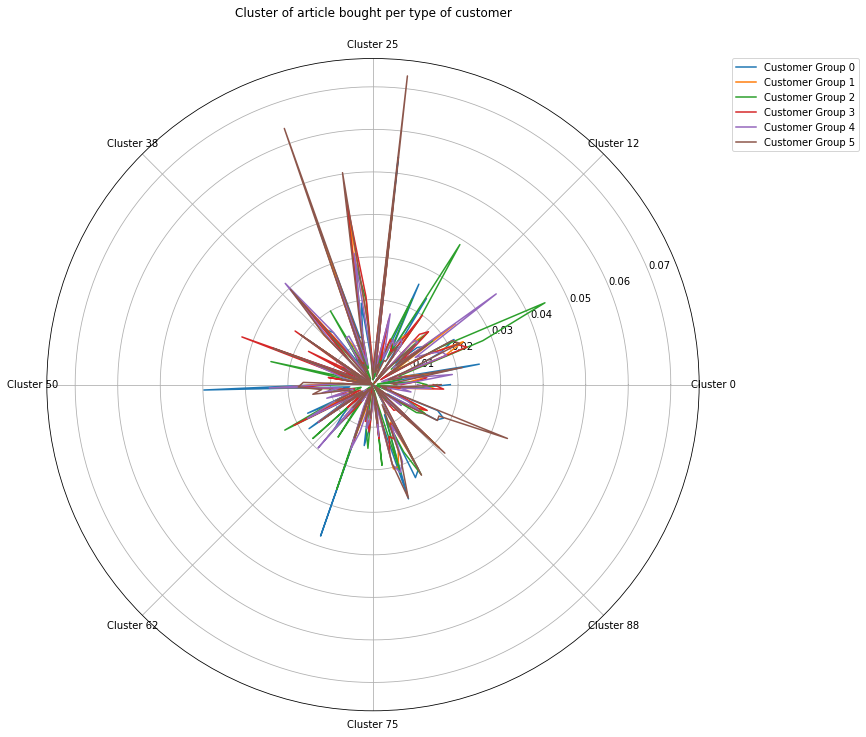

In [48]:
plt.figure(figsize=(15,12))
ax = plt.subplot(111, projection='polar')
theta = 2 * np.pi * np.linspace(0, 1, 100)
matrix = purchase_mean.values

for i in range(6):
    r = matrix[i, :]
    ax.plot(theta, r, label="Customer Group {}".format(i))

ax.set_xticklabels([
    "Cluster 0", "Cluster 12", "Cluster 25", "Cluster 38", 
    "Cluster 50", "Cluster 62", "Cluster 75", "Cluster 88"
])

ax.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title("Cluster of article bought per type of customer", va='bottom')
plt.show()

We can see taht there is some basic clusters where all customer order items and there is some other nearly empty (for example cluster 76). If we have to orient our company, we could reduce the order of this type of parts and focus on main buckets.

# Building Classification Model

We saw that all classes are quite different. For a balance in production, we can guess that a Tree model should work well. At first, we will try it and based on the result, we may change to another model. There is also 2 additionnal good point for this model, we can build the tree an see visually the outcome. But another advantage, is to be able to use raw data without scaling. The evaluation will be done on Cross Validation as we don't have a lot of  customer to also keep a validation dataset (al least for nearly empty clusters). As the smallest cluster has 6 customer, we will use 5 split for the validation and we will track accuracy and the standard deviation between all score. Which means that it's not really repetible.

In [49]:
clusters.shape

(4333,)

In [50]:
classification_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
classification_dataset.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq,cluster,Article_cluster_0,Article_cluster_1,Article_cluster_2,Article_cluster_3,Article_cluster_4,Article_cluster_5,Article_cluster_6,Article_cluster_7,Article_cluster_8,Article_cluster_9,Article_cluster_10,Article_cluster_11,Article_cluster_12,Article_cluster_13,Article_cluster_14,Article_cluster_15,Article_cluster_16,Article_cluster_17,Article_cluster_18,Article_cluster_19,Article_cluster_20,Article_cluster_21,Article_cluster_22,Article_cluster_23,Article_cluster_24,Article_cluster_25,Article_cluster_26,Article_cluster_27,Article_cluster_28,Article_cluster_29,Article_cluster_30,...,Article_cluster_60,Article_cluster_61,Article_cluster_62,Article_cluster_63,Article_cluster_64,Article_cluster_65,Article_cluster_66,Article_cluster_67,Article_cluster_68,Article_cluster_69,Article_cluster_70,Article_cluster_71,Article_cluster_72,Article_cluster_73,Article_cluster_74,Article_cluster_75,Article_cluster_76,Article_cluster_77,Article_cluster_78,Article_cluster_79,Article_cluster_80,Article_cluster_81,Article_cluster_82,Article_cluster_83,Article_cluster_84,Article_cluster_85,Article_cluster_86,Article_cluster_87,Article_cluster_88,Article_cluster_89,Article_cluster_90,Article_cluster_91,Article_cluster_92,Article_cluster_93,Article_cluster_94,Article_cluster_95,Article_cluster_96,Article_cluster_97,Article_cluster_98,Article_cluster_99
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,615.714286,4310.00,7,17.0,2458,1.0,366.0,52.142857,1,0.003852,0.0,0.003081,0.000000,0.000000,0.000000,0.057912,0.004037,0.023596,0.010858,0.002715,0.014246,0.002923,0.00348,0.0,0.015592,0.015278,0.020882,0.003898,0.0,0.001810,0.009466,0.0,0.015220,0.000000,0.000000,0.000000,0.017819,0.044353,0.0,0.007889,...,0.000000,0.004733,0.0,0.00000,0.004594,0.000000,0.0,0.0,0.0,0.003480,0.004037,0.000000,0.0,0.006961,0.0,0.007633,0.008701,0.002088,0.014200,0.063258,0.010970,0.000000,0.106218,0.00348,0.0,0.000000,0.013782,0.003132,0.020589,0.00181,0.002367,0.024501,0.000000,0.015661,0.000000,0.0,0.0,0.000000,0.006125,0.041912
12348,359.310000,1437.24,4,12.0,2332,74.0,357.0,70.750000,1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.403551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.027553,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.042582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.116056,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
12349,1457.550000,1457.55,1,11.0,630,18.0,18.0,0.000000,4,0.000000,0.0,0.000000,0.012247,0.008748,0.012144,0.013584,0.000000,0.012144,0.000000,0.000000,0.000000,0.027409,0.00000,0.0,0.000000,0.038112,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.120716,0.000000,0.000000,0.000000,0.023876,0.047614,0.0,0.000000,...,0.000000,0.000000,0.0,0.01132,0.000000,0.018833,0.0,0.0,0.0,0.079819,0.025852,0.086282,0.0,0.032246,0.0,0.000000,0.000000,0.011938,0.018552,0.008576,0.025625,0.000000,0.000000,0.00000,0.0,0.013584,0.000000,0.000000,0.000000,0.00000,0.000000,0.027196,0.005351,0.043772,0.000000,0.0,0.0,0.017289,0.011320,0.040465
12350,294.400000,294.40,1,27.0,196,309.0,309.0,0.000000,0,0.000000,0.0,0.000000,0.136549,0.000000,0.000000,0.000000,0.230299,0.000000,0.000000,0.000000,0.060122,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.069293,0.000000,0.000000,0.136549,0.000000,0.000000,0.0,0.000000,...,0.063519,0.000000,0.0,0.00000,0.067255,0.000000,0.0,0.0,0.0,0.134511,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0

In [53]:
X = classification_dataset.drop("cluster", axis=1).values
y = classification_dataset["cluster"].values

In [ ]:
min_samples_split = 4 
cv = 5
n_estimators = 40

In [56]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
for max_depth in range(3, 10):
    clf = DecisionTreeClassifier(random_state=0, max_depth=max_depth, min_samples_split=min_samples_split )
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=5, n_jobs=8)
    scores = np.array(scores)
    print("Depth {} : Acc {:.3f} - Dev {:.3f}".format(max_depth, scores.mean(), scores.std()))

In [ ]:
for max_depth in range(3, 10):
    clf = ExtraTreeClassifier(random_state=0, max_depth=max_depth, min_samples_split=min_samples_split )
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=cv, n_jobs=8)
    scores = np.array(scores)
    print("Depth {} : Acc {:.3f} - Dev {:.3f}".format(max_depth, scores.mean(), scores.std()))

In [ ]:
for max_depth in range(3, 10):
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=0, max_depth=max_depth, min_samples_split=min_samples_split )
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=cv, n_jobs=8)
    scores = np.array(scores)
    print("Depth {} : Acc {:.3f} - Dev {:.3f}".format(max_depth, scores.mean(), scores.std()))

In [ ]:
for max_depth in range(3, 10):
    clf = ExtraTreesClassifier(n_estimators=n_estimators, random_state=0, max_depth=max_depth, min_samples_split=min_samples_split )
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=cv, n_jobs=8)
    scores = np.array(scores)
    print("Depth {} : Acc {:.3f} - Dev {:.3f}".format(max_depth, scores.mean(), scores.std()))

The DecisionTreeClassifier is the best in accuracy but the Std Dev is higher than the RandomForestClassifier which have a smaller accuracy. Models usign ExtraTrees are not working as good as Random one so we will exclude them.
At first sight, I'd keep the RandomForestClassifier as we have the benefit to avoid overfitting due to the ensemble of classifier. Let see the confusion matrice for both models :

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf1 = DecisionTreeClassifier(random_state=0, max_depth=9, min_samples_split=4 )
clf2 = RandomForestClassifier(random_state=0, max_depth=9, min_samples_split=4, n_estimators=n_estimators)

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
y_pred2 = clf2.predict(X_test)

In [ ]:
np.unique(y_pred1)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

classes = ["Cluster {}".format(x) for x in range(6)]
np.set_printoptions(precision=2)

plt.figure(figsize=(20,12))
plt.subplot(1, 2, 1)
cnf_matrix = confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, with DecisionTreeClassifier')

plt.subplot(1, 2, 2)
cnf_matrix = confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, with RandomForestClassifier')

plt.show()

So we trained the model with fixed values and a splitted dataset 2/3 for train and 1/3 to test. We can see that there is clearly more mistakes with ensemble learning and not with Random Forest. Moreover, in addition of having more accuracy, it also classify properly the cluster 4 with our VIP customer which is a good point. The main error is between cluster 0 and 1 vs Cluster 5. The main difference is that is some cases we lost the customer. This can be analysed in a good point too. As we classify some customer lost as customer not ofter active, that may mean that they are borderline and we may be able to convert them to permanent customer with some actions. As a result, This model can be used in production

# Conclusion

In this notebook, I tried to explain as much as possible to work done to segment customer based on their behavior. We succeed to find some specific patterns and create a model able to classify them from some of their order. We can also use this work to drive some actions like items to stop purchaing, trending items, detect customer being lost, rewoard our VIP customer and so on. 

I hope you liked it  and feel free to let me know if you have comments or improvements to do on this dataset !